In [58]:
# Read image names
import pandas as pd
df = pd.read_csv("A:/Downloads/retinopathy-dataset-master/newTrainLabels.csv")
df.head(10)

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906
5,15_right,2,0.138600
6,16_left,4,0.151041
7,16_right,4,0.153951
8,17_left,0,0.169070
9,17_right,1,0.174882


In [59]:
# Convert categorical level to binary
import numpy as np
df['level'] = 1*(df['level'] > 0)
df.head(10)

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906
5,15_right,1,0.138600
6,16_left,1,0.151041
7,16_right,1,0.153951
8,17_left,0,0.169070
9,17_right,1,0.174882


In [60]:
# Resample and take only 2000 first rows
df = df.sample(n = 2000, random_state = 2019)
df.head()

,image,level,MB
6962,8753_left,0,0.169470
18925,23879_right,0,0.129349
3904,4903_left,1,0.149969
4283,5387_right,0,0.146645
12023,15083_right,1,0.165109


In [61]:
# Check the size
df.shape

(2000, 3)

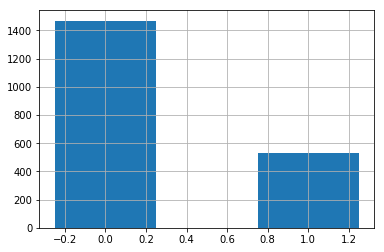

In [62]:
# Create level histogram
df['level'].hist(bins = [0,1, 2], rwidth = 0.5, align = 'left');

In [63]:
# Create image data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.25)

# Data generator for training
train_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "A:/Downloads/retinopathy-dataset-master/train/train/",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "binary", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'training')

# Data generator for validation
valid_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "A:/Downloads/retinopathy-dataset-master/train/train/",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "binary", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'validation')

Found 74 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [64]:
# Create a basic Sequential model with several Conv2D layers

from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
# See: https://keras.io/getting-started/sequential-model-guide/ -> VGG-like convnet
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd,
             loss='binary_crossentropy', 
              metrics = ["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 64)        0         
__________

In [65]:
# Calculate how many batches are needed to go through whole train and validation set
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
N = 10 # Number of epochs

# Train and count time
model_name = strftime('Case2-%Y-%m-%d-%H%M%S.h5', localtime())
t1 = time()
h = model.fit_generator(generator = train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = N,
                    verbose = 2)
t2 = time()
elapsed_time = (t2 - t1)

# Save the model
model.save(model_name)
print('')
print('Model saved to file:', model_name)
print('')

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/N))
print('Total elapsed time for {:d} epochs: {:s}'.format(N, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

Epoch 1/10
 - 21s - loss: 0.6376 - acc: 0.7344 - val_loss: 0.6182 - val_acc: 0.6250
Epoch 2/10
 - 1s - loss: 0.4938 - acc: 0.7852 - val_loss: 0.3080 - val_acc: 1.0000
Epoch 3/10
 - 4s - loss: 0.4543 - acc: 0.7458 - val_loss: 0.5847 - val_acc: 0.6250
Epoch 4/10
 - 6s - loss: 0.3550 - acc: 0.8490 - val_loss: 0.0158 - val_acc: 1.0000
Epoch 5/10
 - 6s - loss: 0.4972 - acc: 0.7383 - val_loss: 0.5552 - val_acc: 0.6250
Epoch 6/10
 - 6s - loss: 0.4515 - acc: 0.7812 - val_loss: 0.1032 - val_acc: 1.0000
Epoch 7/10
 - 6s - loss: 0.4355 - acc: 0.7383 - val_loss: 0.5205 - val_acc: 0.6250
Epoch 8/10
 - 6s - loss: 0.3729 - acc: 0.8180 - val_loss: 0.1247 - val_acc: 1.0000
Epoch 9/10
 - 5s - loss: 0.5204 - acc: 0.7627 - val_loss: 0.5141 - val_acc: 0.6875
Epoch 10/10
 - 6s - loss: 0.4716 - acc: 0.8096 - val_loss: 0.8398 - val_acc: 0.0000e+00

Model saved to file: Case2-2019-03-03-214830.h5

Total elapsed time for 10 epochs: 02:01:07
Average time per epoch:             02:00:06


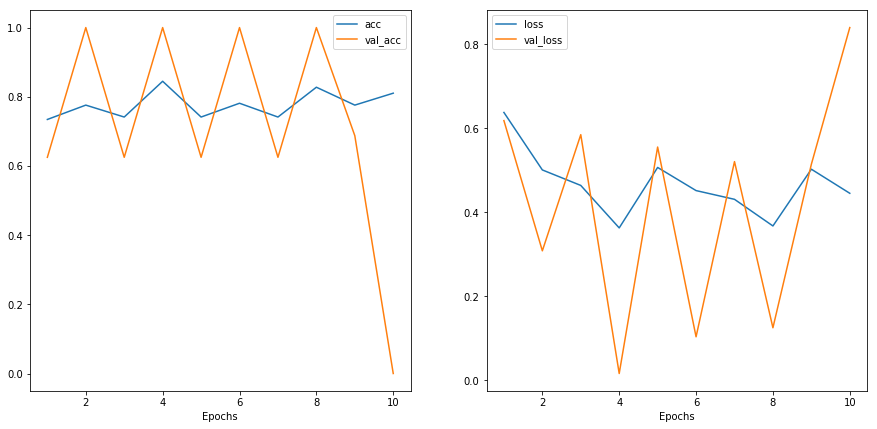

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(N) + 1.0

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

def plotter(ax, epochs, h, variable):
    ax.plot(epochs, h.history[variable], label = variable)
    ax.plot(epochs, h.history['val_' + variable], label = 'val_'+variable)
    ax.set_xlabel('Epochs')
    ax.legend()

plotter(ax1, epochs, h, 'acc')
plotter(ax2, epochs, h, 'loss')
plt.show()

In [67]:
# Calculate the true and predicted values
y_true = valid_generator.classes
predict = model.predict_generator(valid_generator, steps = 20)
y_pred = predict > 0.5

In [68]:
# Calculate and print the metrics results
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(y_true, y_pred)
print('Classification report:')
print(cr)
print('')

ValueError: Found input variables with inconsistent numbers of samples: [17, 170]